In [ ]:
epochs, batch, lr = 100, 32, 1e-4
num_clients, in_channels, num_classes = 6, 1, 10
Dataset, Model, Prefix = 'MNIST', 'CNN_3', 'Attack'
Gdrive = '/content/drive/MyDrive/Colab Notebooks/SplitLearning3'
import torch; torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os; os.chdir(Gdrive)
%run library/Dataset.ipynb
%run library/Network.ipynb
%run library/Training.ipynb
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


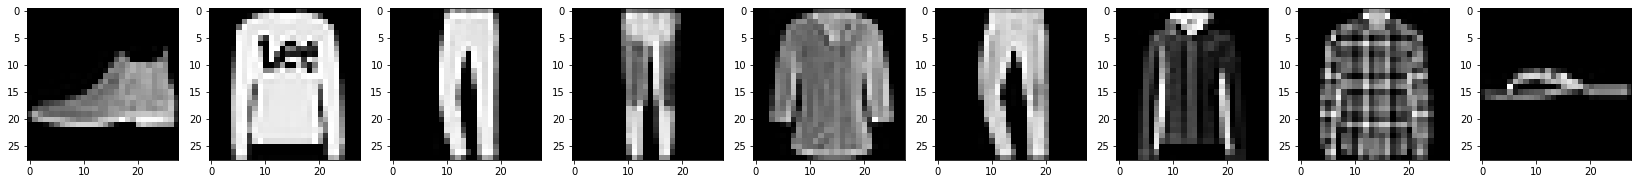

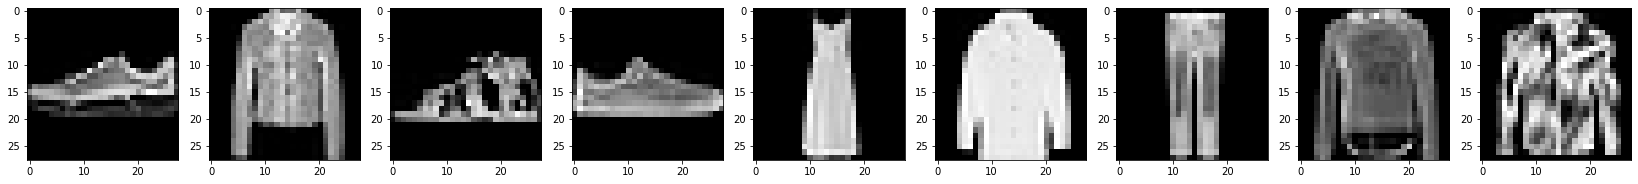

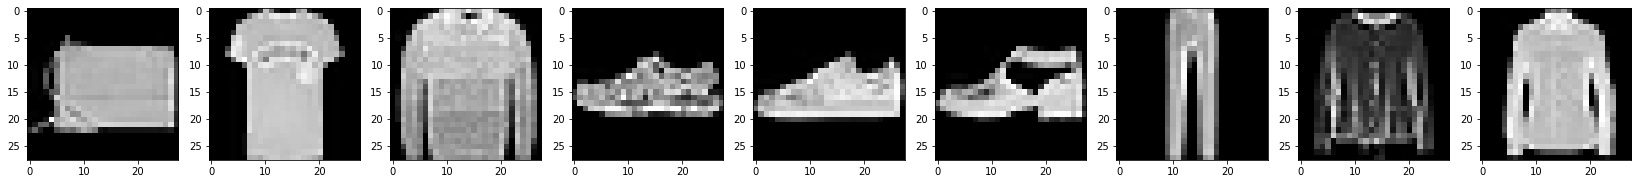

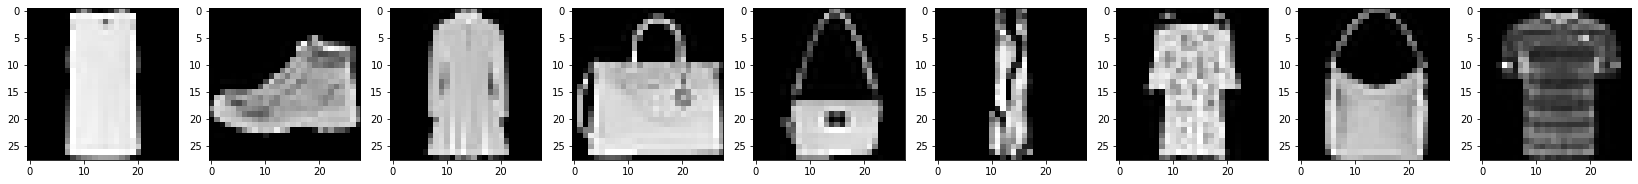

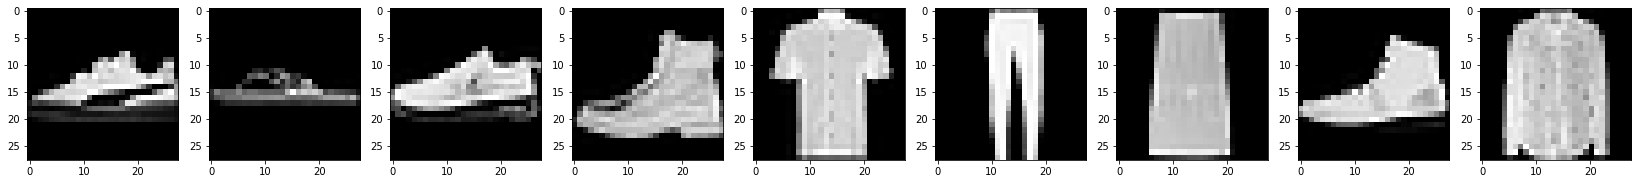

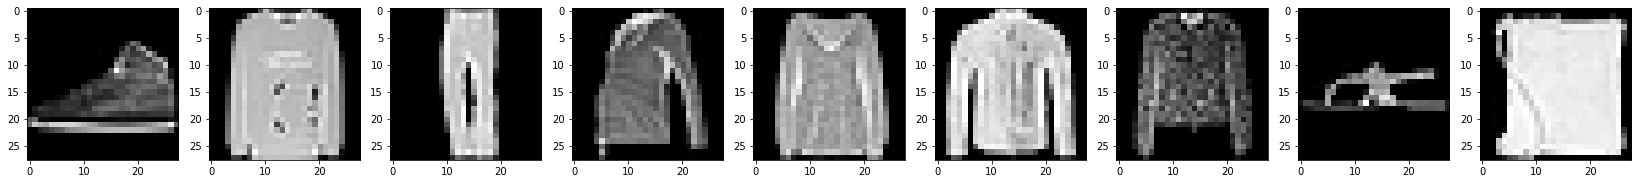

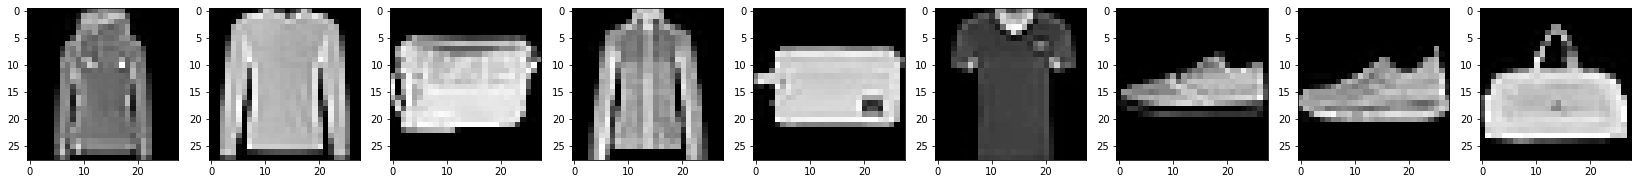

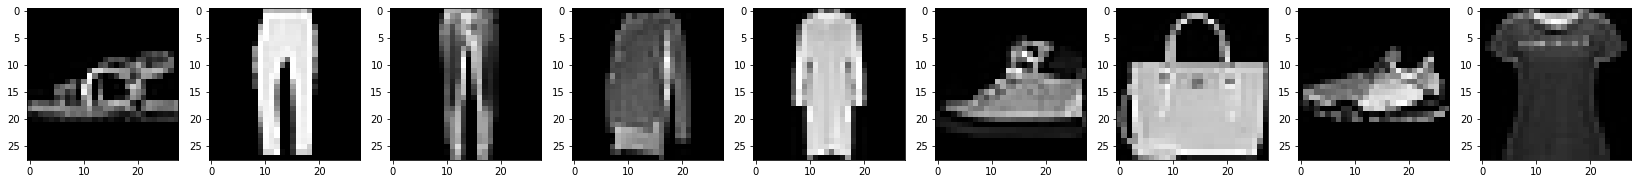

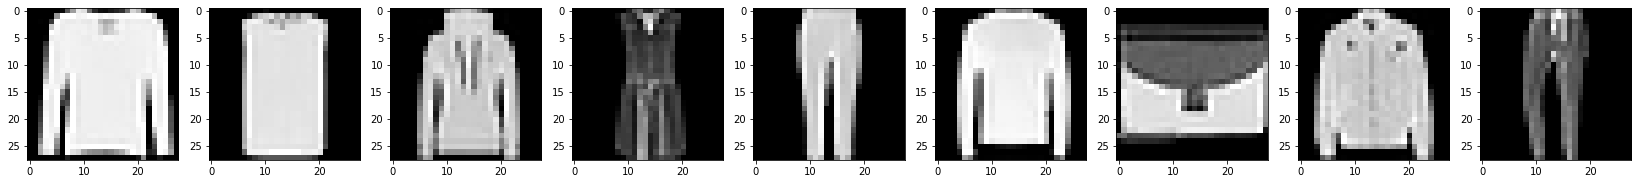

In [ ]:
N = 10
i = 0
for r in range(1, 10):
  plt.figure(figsize=(32,8))
  for c in range(1, N):
    plt.subplot(1, N, c)
    plt.imshow(transforms.ToPILImage()(testset[i][0]), cmap='gray')
    i = i + 1

In [ ]:
!pip install pytorch-msssim
from pytorch_msssim import ssim, SSIM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def reconstruct(decoders):
  image = next(iter(DataLoader(testset)))[0]
  plt.imshow(transforms.ToPILImage()(image[0]))
  plt.figure(figsize=(32,8))
  for i in range(num_clients):
    plt.subplot(1, num_clients, i+1)
    with torch.no_grad():
      network.clients[i].eval(), decoders[i].eval()
      output = decoders[i](network.clients[i](image.cuda()))
    plt.imshow(transforms.ToPILImage()(output.cpu()[0]))
    plt.title(f'{ssim(image, output.cpu(), 1.0)}')

#Leakage

In [ ]:
dataset, testset = loadDataset('Fashion')
clients = torch.ones((num_clients,))
clients = ratio_split(dataset, clients / clients.sum())

In [ ]:
class Decoder(Autodecoder):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 1, 3, 1, 1)
    )
  def forward(self, x):
    return self.model(x)

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7')

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

In [ ]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

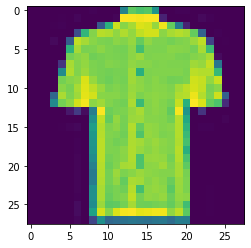

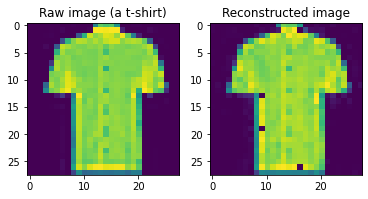

In [ ]:
image = iter(DataLoader(testset))
for i in range(40): next(image)
image = next(image)[0]
plt.imshow(transforms.ToPILImage()(image[0]))
plt.figure()
for i in range(2):
  plt.subplot(1, 2, 1)
  plt.imshow(transforms.ToPILImage()(image[0]))
  plt.title('Raw image (a t-shirt)')
  plt.subplot(1, 2, i+2)
  with torch.no_grad():
    c = 1
    network.clients[c].eval(), decoder.eval()
    output = decoder(network.clients[c](image.cuda()))
  plt.imshow(transforms.ToPILImage()(F.relu(output.cpu()[0])))
  plt.title('Reconstructed image')
  break

#Fashion

In [ ]:
dataset, testset = loadDataset('Fashion')

In [ ]:
clients = torch.ones((num_clients,))
clients = ratio_split(dataset, clients / clients.sum())

In [ ]:
summary(VGG_7(1,10).cuda().client, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
           Dropout-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]               0
            Conv2d-6           [-1, 32, 14, 14]           4,640
       BatchNorm2d-7           [-1, 32, 14, 14]              64
              ReLU-8           [-1, 32, 14, 14]               0
           Dropout-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]               0
Total params: 4,896
Trainable params: 4,896
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.72
Params size (MB): 0.02
Estimated Total

In [ ]:
class Decoder(Autodecoder):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 1, 3, 1, 1)
    )
  def forward(self, x):
    return self.model(x)

summary(Decoder().cuda(), (32, 14, 14))

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'private', 50, 'VGG_7')

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

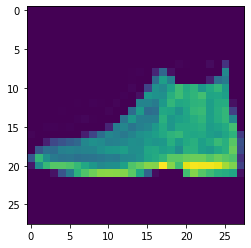

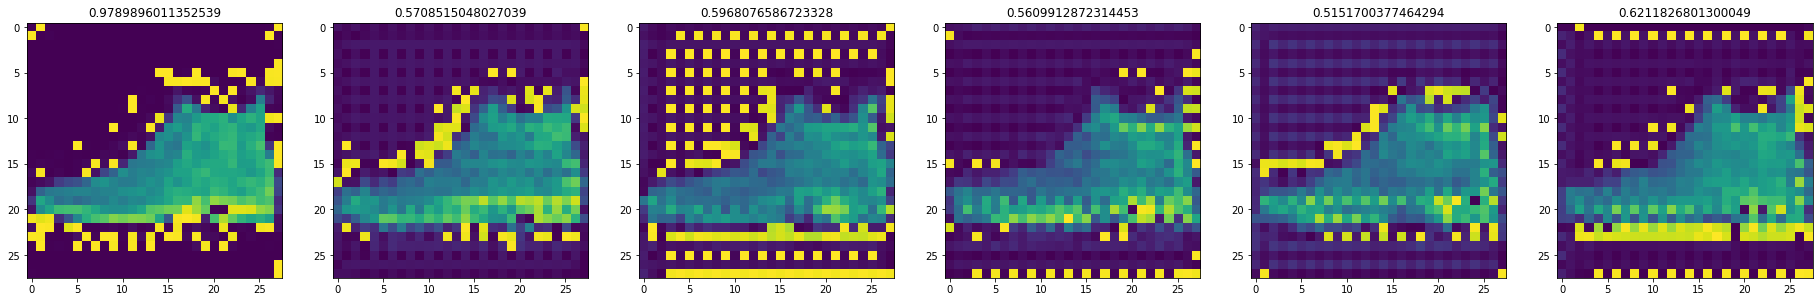

In [ ]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

In [ ]:
for i, client in enumerate(network.clients):
  client.eval(), decoder.eval()
  for images, labels in client.loader:
    output = decoder(client(images))
    print('Client', i, ssim(images, output, 1.0, False).mean())
    break

Client 0 tensor(0.9695, device='cuda:0', grad_fn=<MeanBackward0>)
Client 1 tensor(0.5533, device='cuda:0', grad_fn=<MeanBackward0>)
Client 2 tensor(0.6638, device='cuda:0', grad_fn=<MeanBackward0>)
Client 3 tensor(0.6279, device='cuda:0', grad_fn=<MeanBackward0>)
Client 4 tensor(0.5911, device='cuda:0', grad_fn=<MeanBackward0>)
Client 5 tensor(0.6833, device='cuda:0', grad_fn=<MeanBackward0>)


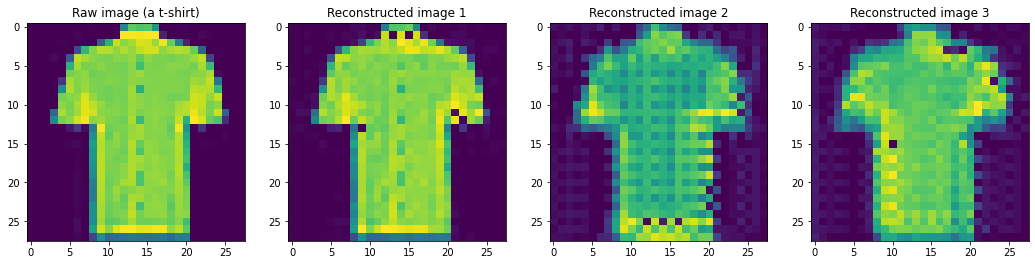

In [ ]:
image = iter(DataLoader(testset))
for i in range(40): next(image)
image = next(image)[0]
plt.figure(figsize=(32,8))
plt.subplot(1, num_clients+1, 1)
plt.imshow(transforms.ToPILImage()(image[0]))
plt.title('Raw image (a t-shirt)')
for i, client in enumerate(network.clients):
  plt.subplot(1, num_clients+1, i+2)
  with torch.no_grad():
    client.eval(), decoder.eval()
    output = decoder(client(image.cuda()))
  plt.imshow(transforms.ToPILImage()(F.relu(output.cpu()[0])))
  plt.title(f'Reconstructed image {i+1}')
  if i > 1: break

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7')

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

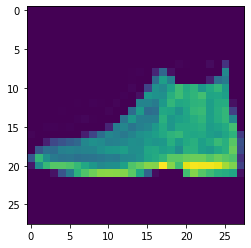

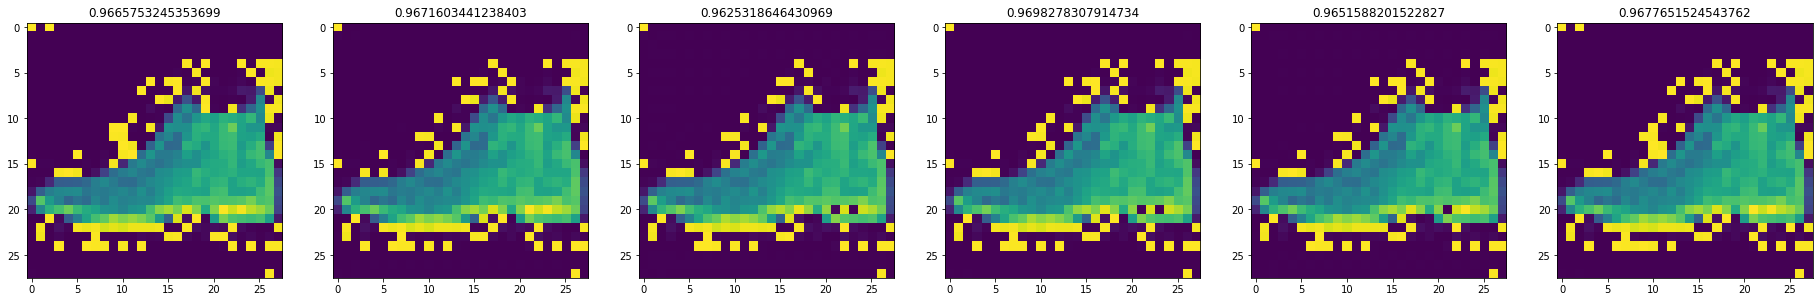

In [ ]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

In [ ]:
for i, client in enumerate(network.clients):
  client.eval(), decoder.eval()
  for images, labels in client.loader:
    output = decoder(client(images))
    print('Client', i, ssim(images, output, 1.0, False).mean())
    break

Client 0 tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
Client 1 tensor(0.9545, device='cuda:0', grad_fn=<MeanBackward0>)
Client 2 tensor(0.9510, device='cuda:0', grad_fn=<MeanBackward0>)
Client 3 tensor(0.9689, device='cuda:0', grad_fn=<MeanBackward0>)
Client 4 tensor(0.9412, device='cuda:0', grad_fn=<MeanBackward0>)
Client 5 tensor(0.9588, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'federate', 50, 'VGG_7')

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

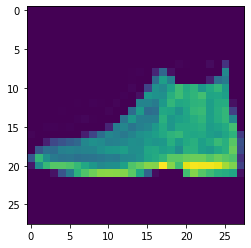

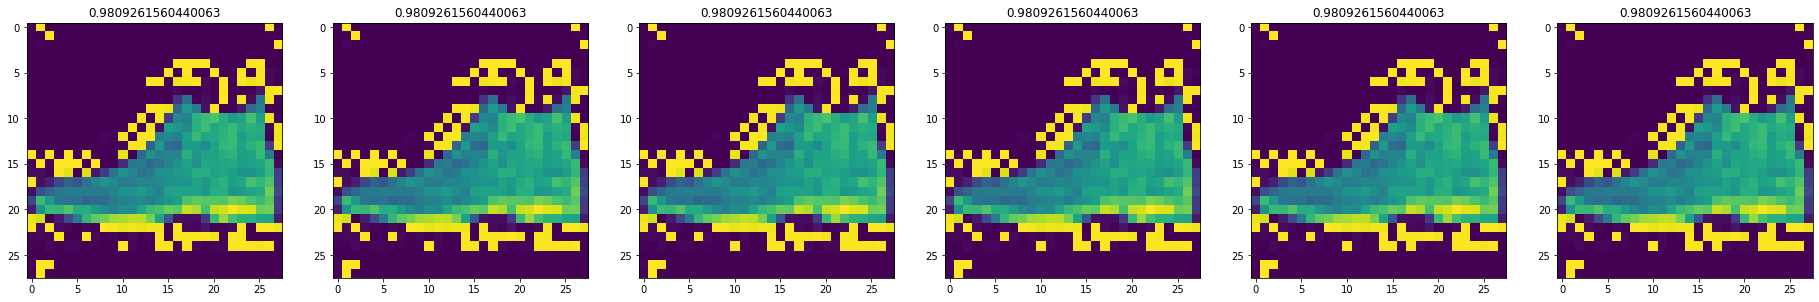

In [ ]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])

In [ ]:
for i, client in enumerate(network.clients):
  client.eval(), decoder.eval()
  for images, labels in client.loader:
    output = decoder(client(images))
    print('Client', i, ssim(images, output, 1.0, False).mean())
    break

Client 0 tensor(0.9714, device='cuda:0', grad_fn=<MeanBackward0>)
Client 1 tensor(0.9701, device='cuda:0', grad_fn=<MeanBackward0>)
Client 2 tensor(0.9674, device='cuda:0', grad_fn=<MeanBackward0>)
Client 3 tensor(0.9676, device='cuda:0', grad_fn=<MeanBackward0>)
Client 4 tensor(0.9727, device='cuda:0', grad_fn=<MeanBackward0>)
Client 5 tensor(0.9734, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
clients = np.array([1, 3, 9, 19, 30, 38])
clients = ratio_split(dataset, clients / clients.sum())
network = train_splitnn(clients, (testset, 1, 10), 'private', 50, 'VGG_7')

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

Client 0 tensor(0.9027, device='cuda:0', grad_fn=<MeanBackward0>)
Client 1 tensor(0.3208, device='cuda:0', grad_fn=<MeanBackward0>)
Client 2 tensor(0.5294, device='cuda:0', grad_fn=<MeanBackward0>)
Client 3 tensor(0.4413, device='cuda:0', grad_fn=<MeanBackward0>)
Client 4 tensor(0.3953, device='cuda:0', grad_fn=<MeanBackward0>)
Client 5 tensor(0.3678, device='cuda:0', grad_fn=<MeanBackward0>)


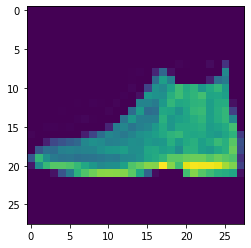

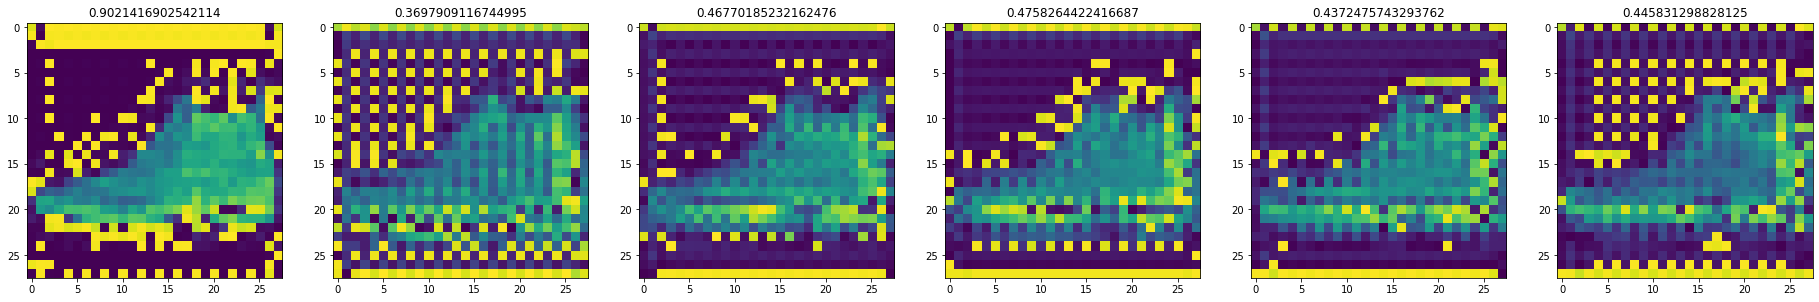

In [ ]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[0], 30)
reconstruct([decoder for i in range(num_clients)])
for i, client in enumerate(network.clients):
  client.eval(), decoder.eval()
  for images, labels in client.loader:
    output = decoder(client(images))
    print('Client', i, ssim(images, output, 1.0, False).mean())
    break

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

Client 0 tensor(0.4276, device='cuda:0', grad_fn=<MeanBackward0>)
Client 1 tensor(0.4532, device='cuda:0', grad_fn=<MeanBackward0>)
Client 2 tensor(0.6024, device='cuda:0', grad_fn=<MeanBackward0>)
Client 3 tensor(0.7084, device='cuda:0', grad_fn=<MeanBackward0>)
Client 4 tensor(0.7337, device='cuda:0', grad_fn=<MeanBackward0>)
Client 5 tensor(0.9680, device='cuda:0', grad_fn=<MeanBackward0>)


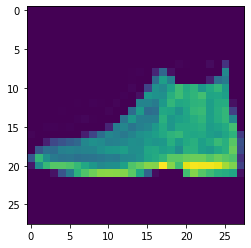

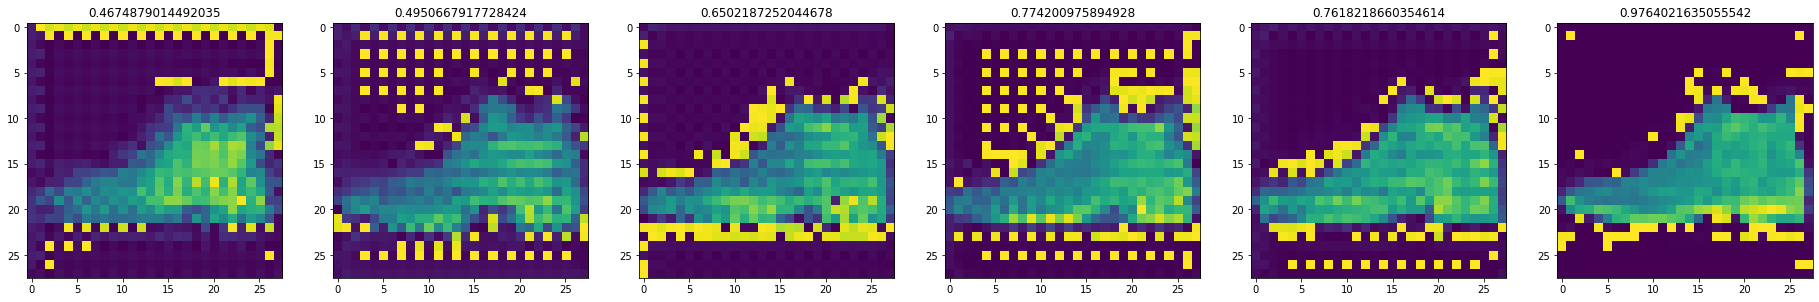

In [ ]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[5], network.clients[5], 30)
reconstruct([decoder for i in range(num_clients)])
for i, client in enumerate(network.clients):
  client.eval(), decoder.eval()
  for images, labels in client.loader:
    output = decoder(client(images))
    print('Client', i, ssim(images, output, 1.0, False).mean())
    break

In [ ]:
class Decoder2(Autodecoder):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.ConvTranspose2d(32, 24, 3, 2, 1, 1),
      nn.ReLU(),
      nn.ConvTranspose2d(24, 16, 3, 1, 1, 0),
      nn.ReLU(),
      nn.ConvTranspose2d(16, 8, 3, 1, 1, 0),
      nn.ReLU(),
      nn.ConvTranspose2d(8, 1, 3, 1, 1)
    )
  def forward(self, x):
    return self.model(x)

summary(Decoder().cuda(), (32, 14, 14))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 16, 28, 28]           4,624
              ReLU-2           [-1, 16, 28, 28]               0
   ConvTranspose2d-3            [-1, 1, 28, 28]             145
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.20
Params size (MB): 0.02
Estimated Total Size (MB): 0.24
----------------------------------------------------------------


  0%|          | 0/50 [00:00<?, ?it/s]

Output()

Client 0 tensor(0.9534, device='cuda:0', grad_fn=<MeanBackward0>)
Client 1 tensor(0.3166, device='cuda:0', grad_fn=<MeanBackward0>)
Client 2 tensor(0.5066, device='cuda:0', grad_fn=<MeanBackward0>)
Client 3 tensor(0.5255, device='cuda:0', grad_fn=<MeanBackward0>)
Client 4 tensor(0.4751, device='cuda:0', grad_fn=<MeanBackward0>)
Client 5 tensor(0.3924, device='cuda:0', grad_fn=<MeanBackward0>)


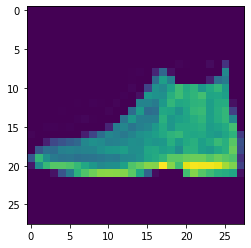

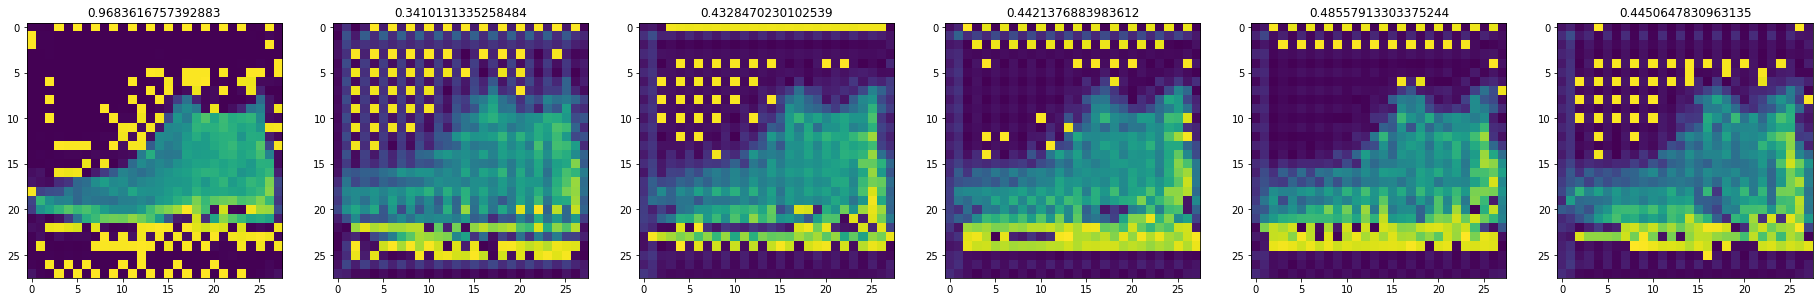

In [ ]:
decoder = Decoder2().cuda()
decoder.train_model(network.clients[0], network.clients[0], 50)
reconstruct([decoder for i in range(num_clients)])
for i, client in enumerate(network.clients):
  client.eval(), decoder.eval()
  for images, labels in client.loader:
    output = decoder(client(images))
    print('Client', i, ssim(images, output, 1.0, False).mean())
    break

In [ ]:
clients = torch.ones((num_clients,))
clients = ratio_split(dataset, clients / clients.sum())
network = train_splitnn(clients, (testset, 1, 10), 'private', 50, 'VGG_7')

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

In [ ]:
for i, client in enumerate(network.clients):
  client.eval()
  for images, labels in client.loader:
    output = client(images).reshape(-1, 14, 14)
    output = torch.stack([transforms.ToTensor()(transforms.Resize((28,28))(transforms.ToPILImage()(img))) for img in output])
    print('Client', i, ssim(images.expand(-1, 32, -1, -1).reshape(-1, 1, 28, 28), output.cuda(), 1.0, True))
    break

Client 0 tensor(0.0644, device='cuda:0')
Client 1 tensor(0.0599, device='cuda:0')
Client 2 tensor(0.0885, device='cuda:0')
Client 3 tensor(0.0727, device='cuda:0')
Client 4 tensor(0.0822, device='cuda:0')
Client 5 tensor(0.0776, device='cuda:0')


  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

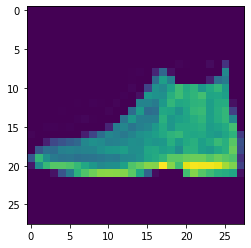

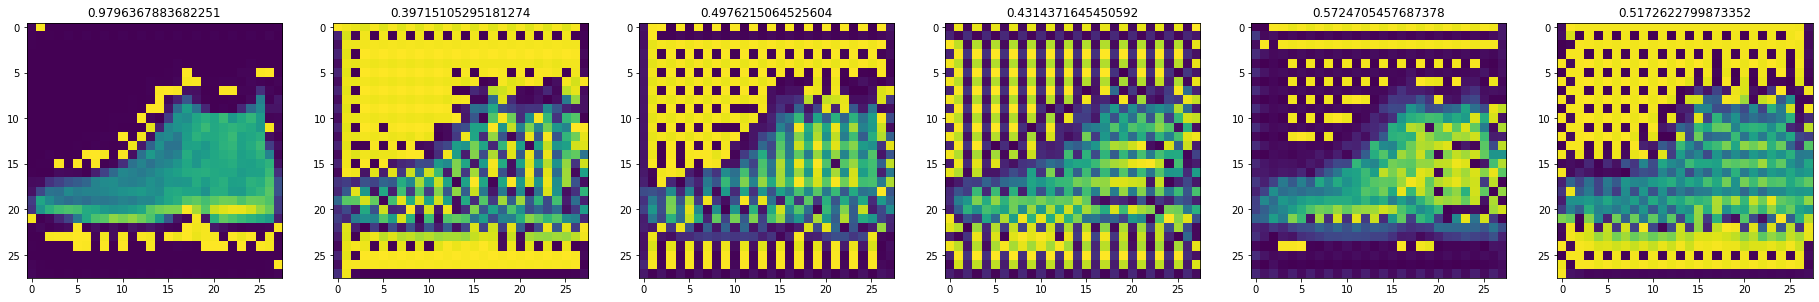

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'private', 50, 'VGG_7')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[1], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

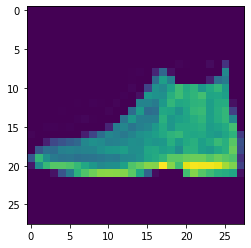

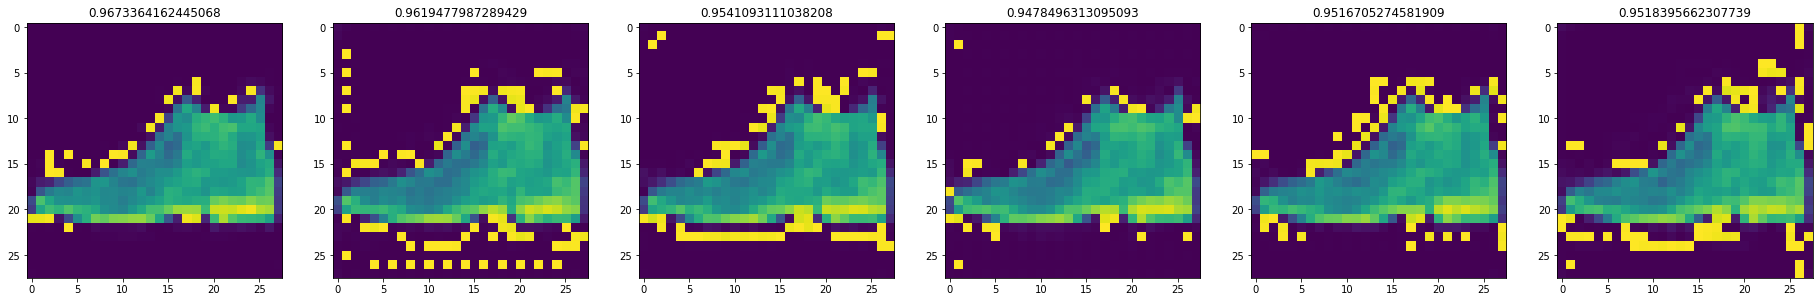

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 50, 'VGG_7')
decoders = [Decoder().cuda() for c in network.clients]
for i in tqdm(range(len(network.clients))):
  j = (i + 1) % len(network.clients)
  network.clients[i].loader, network.clients[j].loader = network.clients[j].loader, network.clients[i].loader
  decoders[i].train_model(network.clients[i], network.clients[j], 30)
  network.clients[i].loader, network.clients[j].loader = network.clients[j].loader, network.clients[i].loader
reconstruct(decoders)

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

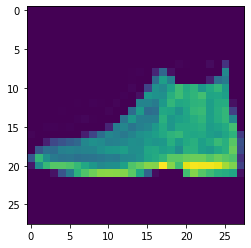

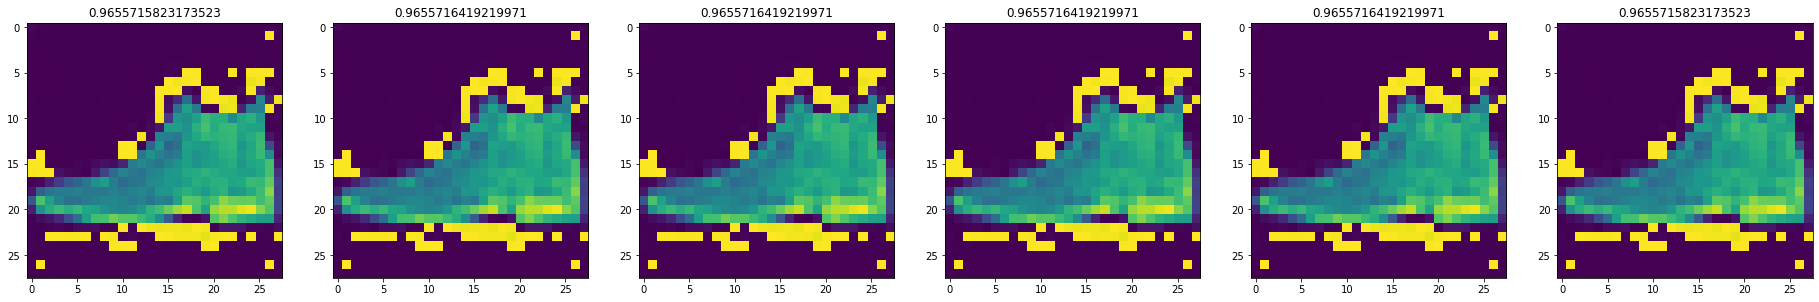

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'federate', 50, 'VGG_7')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[1], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

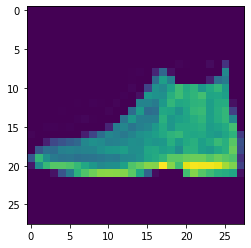

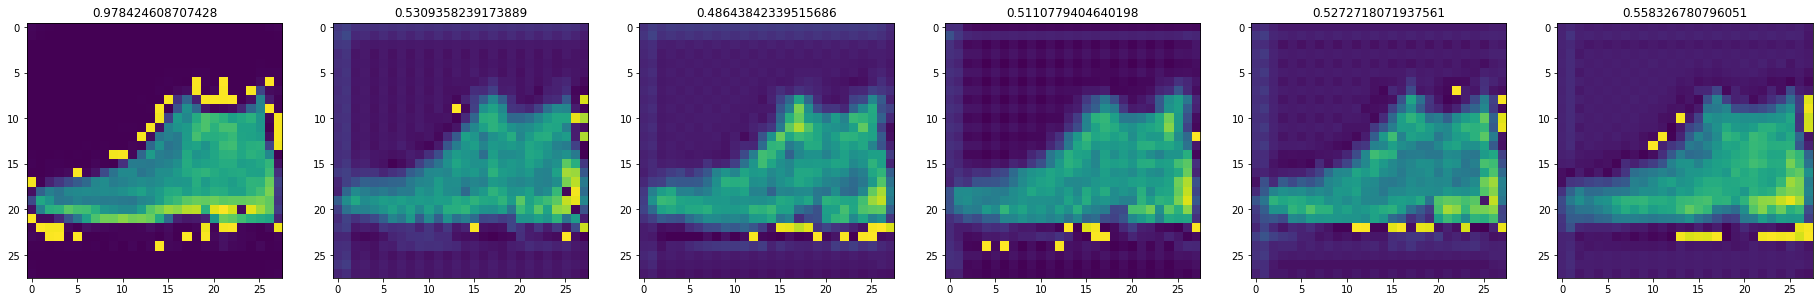

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'private', 50, 'VGG_7')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[1], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

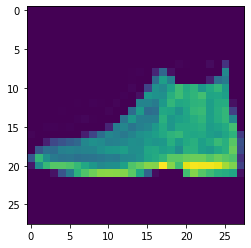

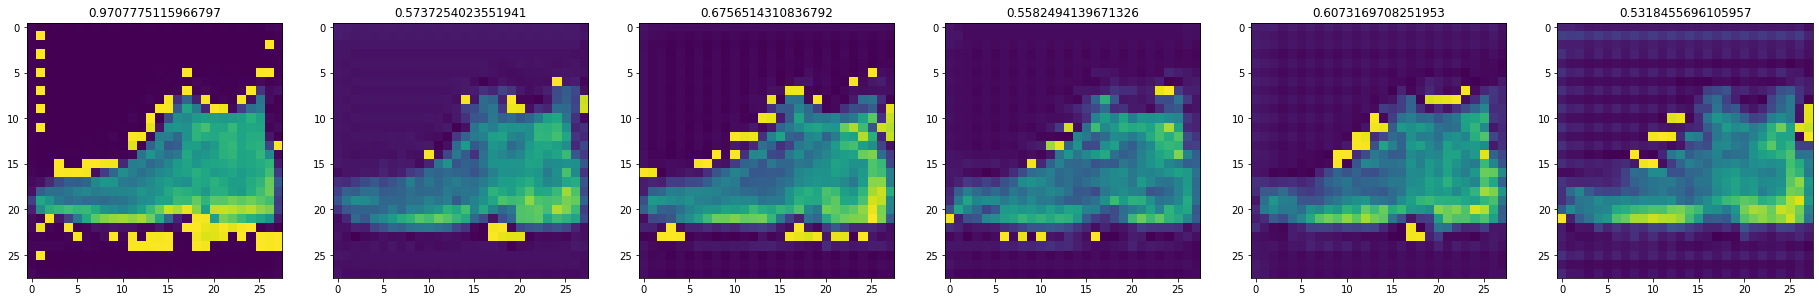

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence_private', 50, 'VGG_7')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[1], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

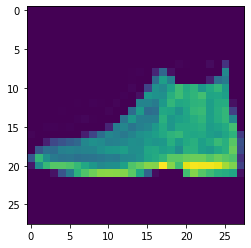

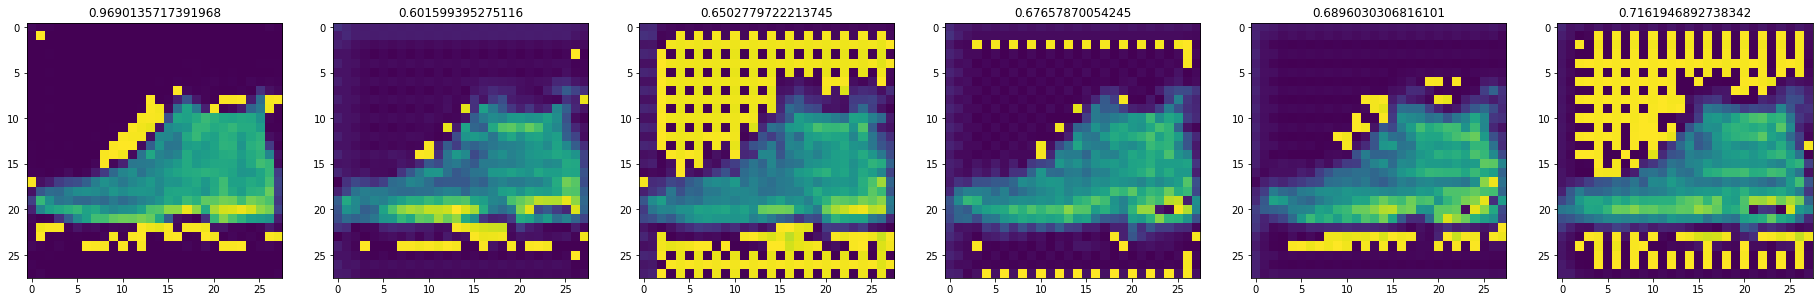

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'federate_private', 50, 'VGG_7')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[1], 30)
reconstruct([decoder for i in range(num_clients)])

##Private

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'private', 50, 'VGG_7')

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

In [ ]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[1], 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

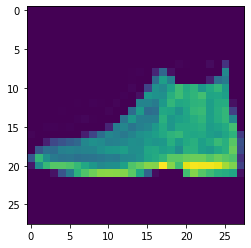

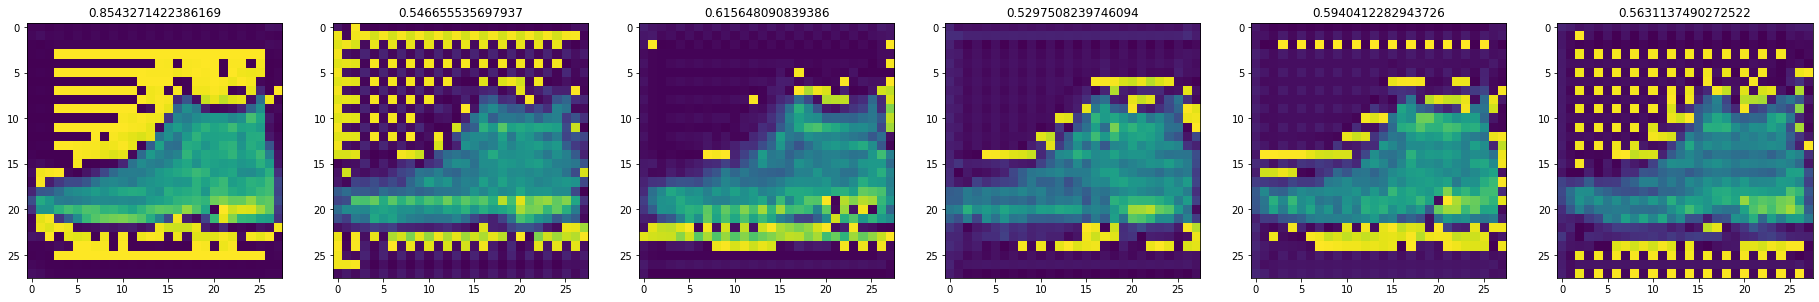

In [ ]:
image = next(iter(DataLoader(testset)))[0]
plt.imshow(transforms.ToPILImage()(image[0]))
plt.figure(figsize=(32,8))
for i in range(num_clients):
  plt.subplot(1, num_clients, i+1)
  with torch.no_grad():
    network.clients[i].eval(), decoder.eval()
    output = decoder(network.clients[i](image.cuda()))
  plt.imshow(transforms.ToPILImage()(output.cpu()[0]))
  plt.title(f'{ssim(image, output.cpu(), 1.0)}')

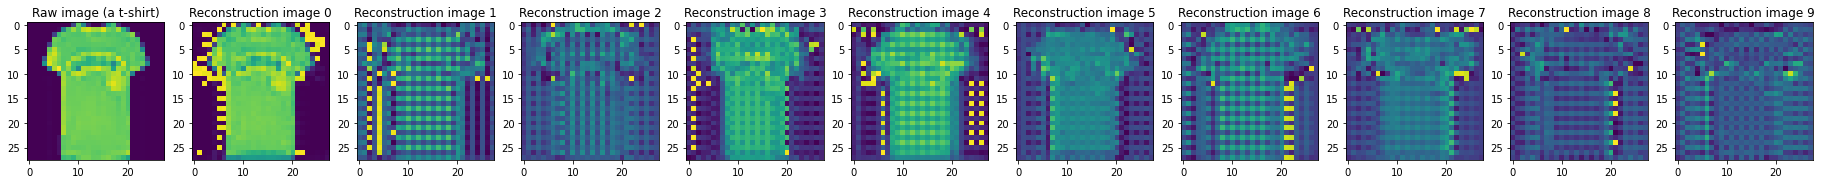

In [ ]:
image = iter(DataLoader(testset))
for i in range(19): next(image)
image = next(image)[0]
plt.figure(figsize=(32,8))
plt.subplot(1, num_clients+1, 1)
plt.imshow(transforms.ToPILImage()(image[0]))
plt.title('Raw image (a t-shirt)')
for i, client in enumerate(network.clients):
  plt.subplot(1, num_clients+1, i+2)
  with torch.no_grad():
    client.eval(), decoder.eval()
    output = decoder(client(image.cuda()))
  plt.imshow(transforms.ToPILImage()(output.cpu()[0]))
  plt.title(f'Reconstruction image {i}')

In [ ]:
network.server.train()
for client in tqdm(network.clients):
  client.train(); client.cached = []
  for images, labels in client.loader:
    client.zero_grad(), network.server.zero_grad()
    output = network.server(client(images))
    client.cached.append((client.output.detach(), images))
    loss = F.cross_entropy(output, labels)
    client.backward(network.server.backward(loss))
    client.optim_step(), network.server.optim_step()

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
decoder.eval()
similarity = []
for client in tqdm(network.clients):
  similarity.append([ssim(images, decoder(output), 1, nonnegative_ssim=True) for output, images in client.cached])
  client.cached = None; del client.cached; torch.cuda.empty_cache() #release memory
[sum(s)/len(s) for s in similarity]

  0%|          | 0/10 [00:00<?, ?it/s]

[tensor(0.9455, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0656, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1401, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3429, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.3299, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.2404, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1795, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.1575, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0840, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0135, device='cuda:0', grad_fn=<DivBackward0>)]

##Federate

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'federate', 20, 'VGG_7')

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

In [ ]:
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[1], 20)

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

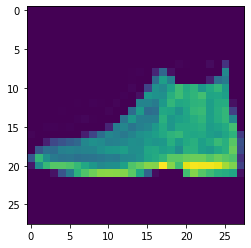

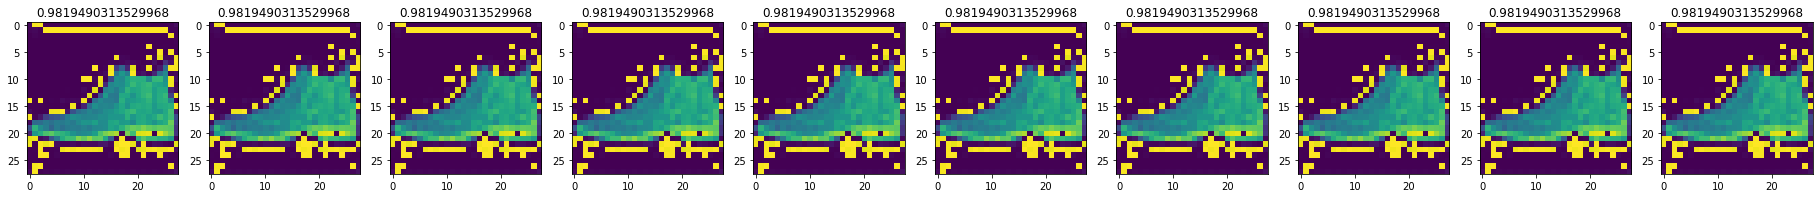

In [ ]:
image = next(iter(DataLoader(testset)))[0]
plt.imshow(transforms.ToPILImage()(image[0]))
plt.figure(figsize=(32,8))
for i in range(num_clients):
  plt.subplot(1, num_clients, i+1)
  with torch.no_grad():
    network.clients[i].eval(), decoder.eval()
    output = decoder(network.clients[i](image.cuda()))
  plt.imshow(transforms.ToPILImage()(output.cpu()[0]))
  plt.title(f'{ssim(image, output.cpu(), 1.0)}')

In [ ]:
network.server.train()
for client in tqdm(network.clients):
  client.train(); client.cached = []
  for images, labels in client.loader:
    client.zero_grad(), network.server.zero_grad()
    output = network.server(client(images))
    client.cached.append((client.output.detach(), images))
    loss = F.cross_entropy(output, labels)
    client.backward(network.server.backward(loss))
    client.optim_step(), network.server.optim_step()

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
decoder.eval()
similarity = []
for client in tqdm(network.clients):
  similarity.append([ssim(images, decoder(output), 1, nonnegative_ssim=True) for output, images in client.cached])
  client.cached = None; del client.cached; torch.cuda.empty_cache() #release memory
[sum(s)/len(s) for s in similarity]

  0%|          | 0/10 [00:00<?, ?it/s]

[tensor(0.9394, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9445, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9414, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9347, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9431, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9392, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9438, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9442, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9448, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9386, device='cuda:0', grad_fn=<DivBackward0>)]

##Sequence

In [ ]:
network = train_splitnn(clients, (testset, 1, 10), 'sequence', 20, 'VGG_7')

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

In [ ]:
decoders = [Decoder().cuda() for c in network.clients]
for i in tqdm(range(len(network.clients))):
  j = (i + 1) % len(network.clients)
  network.clients[i].loader, network.clients[j].loader = network.clients[j].loader, network.clients[i].loader
  decoders[i].train_model(network.clients[i], network.clients[j], 20)
  network.clients[i].loader, network.clients[j].loader = network.clients[j].loader, network.clients[i].loader

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

  0%|          | 0/20 [00:00<?, ?it/s]

Output()

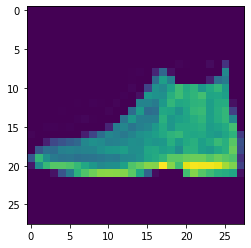

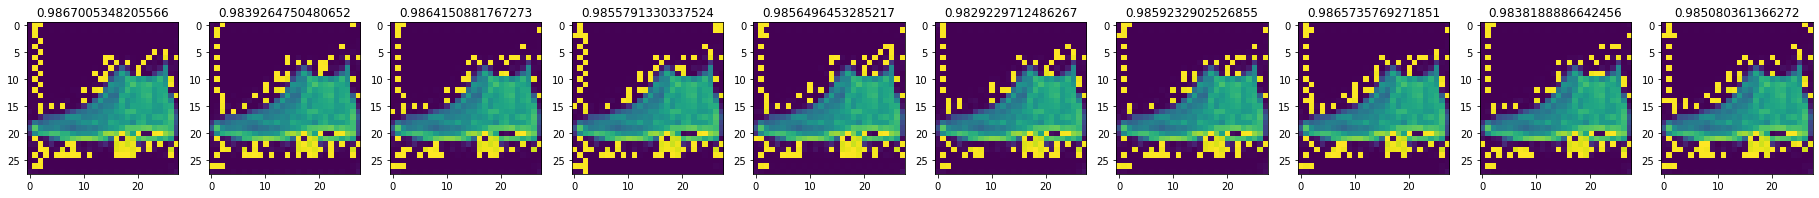

In [ ]:
image = next(iter(DataLoader(testset)))[0]
plt.imshow(transforms.ToPILImage()(image[0]))
plt.figure(figsize=(32,8))
for i in range(num_clients):
  plt.subplot(1, num_clients, i+1)
  with torch.no_grad():
    network.clients[i].eval(), decoders[i].eval()
    output = decoders[i](network.clients[i](image.cuda()))
  plt.imshow(transforms.ToPILImage()(output.cpu()[0]))
  plt.title(f'{ssim(image, output.cpu(), 1.0)}')

In [ ]:
network.server.train()
model = network.clients[-1].state_dict()
for client in tqdm(network.clients):
  client.load_state_dict(model)
  client.train(); client.cached = []
  for images, labels in client.loader:
    client.zero_grad(), network.server.zero_grad()
    output = network.server(client(images))
    client.cached.append((client.output.detach(), images))
    loss = F.cross_entropy(output, labels)
    client.backward(network.server.backward(loss))
    client.optim_step(), network.server.optim_step()
  model = client.state_dict()

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
similarity = []
for i, client in tqdm(enumerate(network.clients)):
  decoders[i].eval()
  similarity.append([ssim(images, decoders[i](output), 1, nonnegative_ssim=True) for output, images in client.cached])
  client.cached = None; del client.cached; torch.cuda.empty_cache() #release memory
[sum(s)/len(s) for s in similarity]

0it [00:00, ?it/s]

[tensor(0.9420, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9452, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9462, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9396, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9446, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9472, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9391, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9425, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9472, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9439, device='cuda:0', grad_fn=<DivBackward0>)]

#CIFAR

In [ ]:
dataset, testset = loadDataset('CIFAR')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content/
Files already downloaded and verified


In [ ]:
clients = torch.ones((num_clients,))
clients = ratio_split(dataset, clients / clients.sum())

In [ ]:
summary(VGG_11(3,10).cuda().client, (3,32,32))

In [ ]:
class Decoder(Autodecoder):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
      nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
      nn.ReLU(), nn.Dropout(0.3),
      nn.ConvTranspose2d(32, 16, 3, 1, 1),
      nn.ReLU(), nn.Dropout(0.3),
      nn.ConvTranspose2d(16, 3, 3, 1, 1)
    )
  def forward(self, x):
    return self.model(x)

summary(Decoder().cuda(), (64, 16, 16))

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

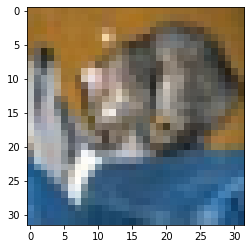

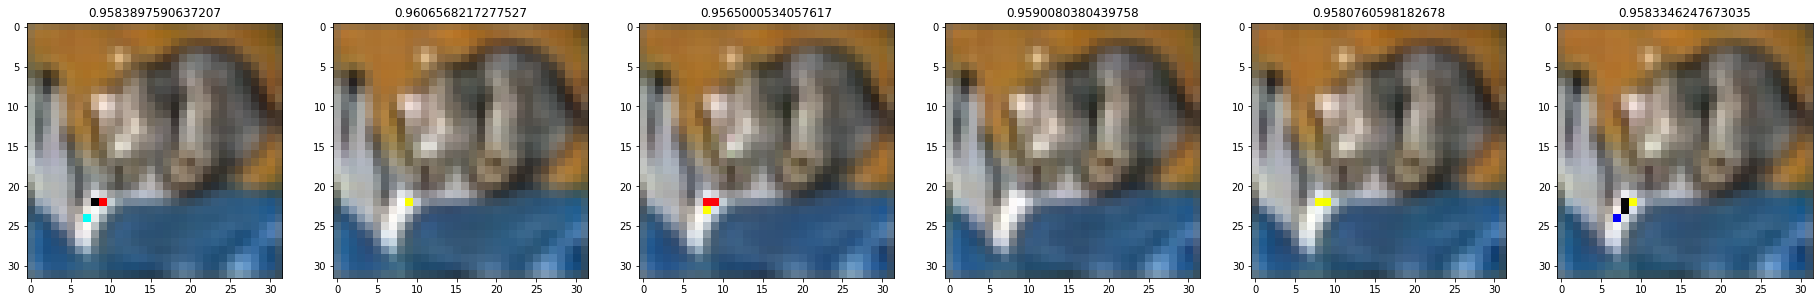

In [ ]:
network = train_splitnn(clients, (testset, 3, 10), 'sequence', 50, 'VGG_11')
decoders = [Decoder().cuda() for c in network.clients]
for i in tqdm(range(len(network.clients))):
  j = (i + 1) % len(network.clients)
  network.clients[i].loader, network.clients[j].loader = network.clients[j].loader, network.clients[i].loader
  decoders[i].train_model(network.clients[i], network.clients[j], 30)
  network.clients[i].loader, network.clients[j].loader = network.clients[j].loader, network.clients[i].loader
reconstruct(decoders)

In [ ]:
class VGG_11(VGGNet):
  def __init__(self, in_channels, num_classes, dropout=(0.5,0.5)):
    super().__init__([(128,1), (128,2), (256,1), (256,2), (512,1), (512,2), (512,1), (512,2)], 64, dropout[1])
    self.client = self.mobile(in_channels, 64, dropout[0])
    self.server.append(nn.Flatten())
    self.server.append(nn.Linear(512, num_classes))

In [ ]:
network = train_splitnn([dataset], (testset, 3, 10), 'private', 100, 'VGG_11')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[1], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/100 [00:00<?, ?it/s]

Output()

KeyboardInterrupt: ignored

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

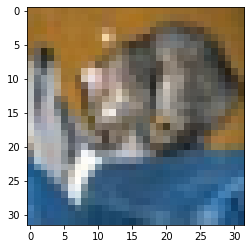

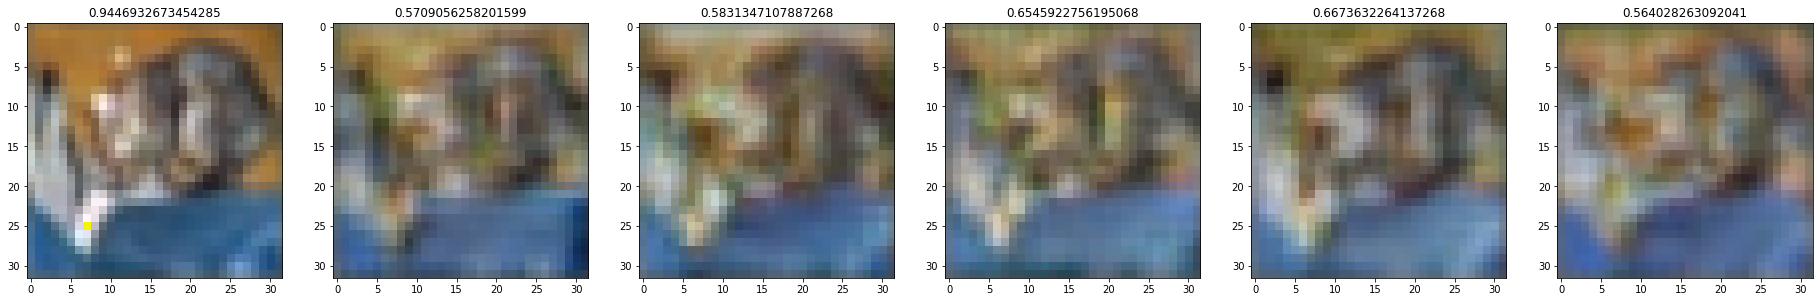

In [ ]:
network = train_splitnn(clients, (testset, 3, 10), 'sequence_private', 50, 'VGG_11')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[1], 30)
reconstruct([decoder for i in range(num_clients)])

  0%|          | 0/50 [00:00<?, ?it/s]

Output()

  0%|          | 0/30 [00:00<?, ?it/s]

Output()

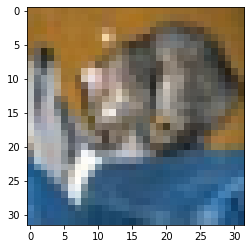

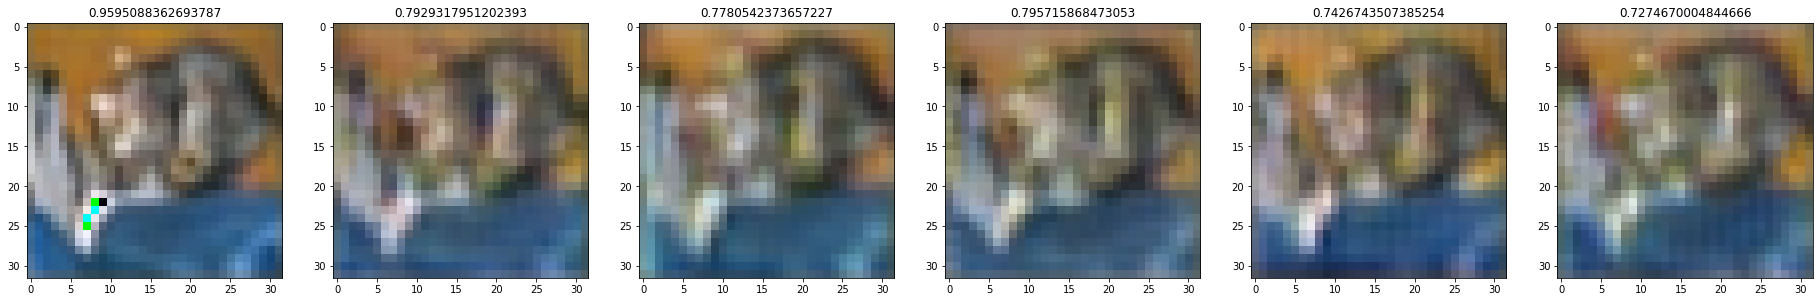

In [ ]:
network = train_splitnn(clients, (testset, 3, 10), 'federate_private', 50, 'VGG_11')
decoder = Decoder().cuda()
decoder.train_model(network.clients[0], network.clients[1], 30)
reconstruct([decoder for i in range(num_clients)])